<CENTER>
<p><font size="5"> Big Data </span></p>
<p><font size="5"> HMEQ DATASET </font></p>
</p>
</CENTER>

<span style="border-bottom: 2px solid orange;">INTRODUCTION : </span>



In [1]:
# We import the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

#math
from scipy.stats import uniform
import itertools

# for potential feature engineering
from sklearn.preprocessing import PolynomialFeatures

#For our classification model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Evaluation metrics
from sklearn.metrics import (
    confusion_matrix,           # Counts of TP, TN, FP, FN
    classification_report,      # Precision, recall, F1 summary
    roc_curve, auc,            # ROC curve and AUC
    roc_auc_score,             # AUC score directly
    ConfusionMatrixDisplay     # Visualization
)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

In [2]:
# Load the whole dataset

df_hmeq = pd.read_csv("raw_data/hmeq.csv")
print(f"Dataset SHape : {df_hmeq.shape}")
print(f"Here are the columns : {df_hmeq.columns.to_list()}")
df_hmeq.head()

Dataset SHape : (5960, 13)
Here are the columns : ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
print("Target variable distribution:")
print(df_hmeq['BAD'].value_counts())
print(f"\nDefault rate: {df_hmeq['BAD'].mean():.1%}")
print(f"  - Non-defaults: {(df_hmeq['BAD']==0).sum():,}")
print(f"  - Defaults: {(df_hmeq['BAD']==1).sum():,}")

Target variable distribution:
BAD
0    4771
1    1189
Name: count, dtype: int64

Default rate: 19.9%
  - Non-defaults: 4,771
  - Defaults: 1,189


In [4]:
df_hmeq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [5]:
num_cols = df_hmeq.select_dtypes(include=['float64', 'int64']) 
cat_cols = df_hmeq.select_dtypes(include=['object']) 

print("Numeric Variables:")
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

Categorical Variables:
['REASON', 'JOB']


We can already see that some data is missing (row "count"). This is a serious problem because if some rows are taking into account for the traning of our model, that could alter the F1 score. Most of the data is numerical and only two columns are strings : REASON and JOB ! 

In [6]:
for col in cat_cols:
    print('We Have {} Unique Values. Values in the {} Column: {}'.format(len(df_hmeq[col].unique()),col,df_hmeq[col].unique()))
    print('__'*30)



We Have 3 Unique Values. Values in the REASON Column: ['HomeImp' nan 'DebtCon']
____________________________________________________________
We Have 7 Unique Values. Values in the JOB Column: ['Other' nan 'Office' 'Sales' 'Mgr' 'ProfExe' 'Self']
____________________________________________________________


In [7]:
print("The count of the missing values for each variable :")
df_hmeq.isnull().sum()

The count of the missing values for each variable :


BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

<span style="border-bottom: 2px solid lime;">Distributions for continuous variables : </span> LOAN (with no null values), MORTDUE, VALUE, YOJ, CLAGE, DEBTINC

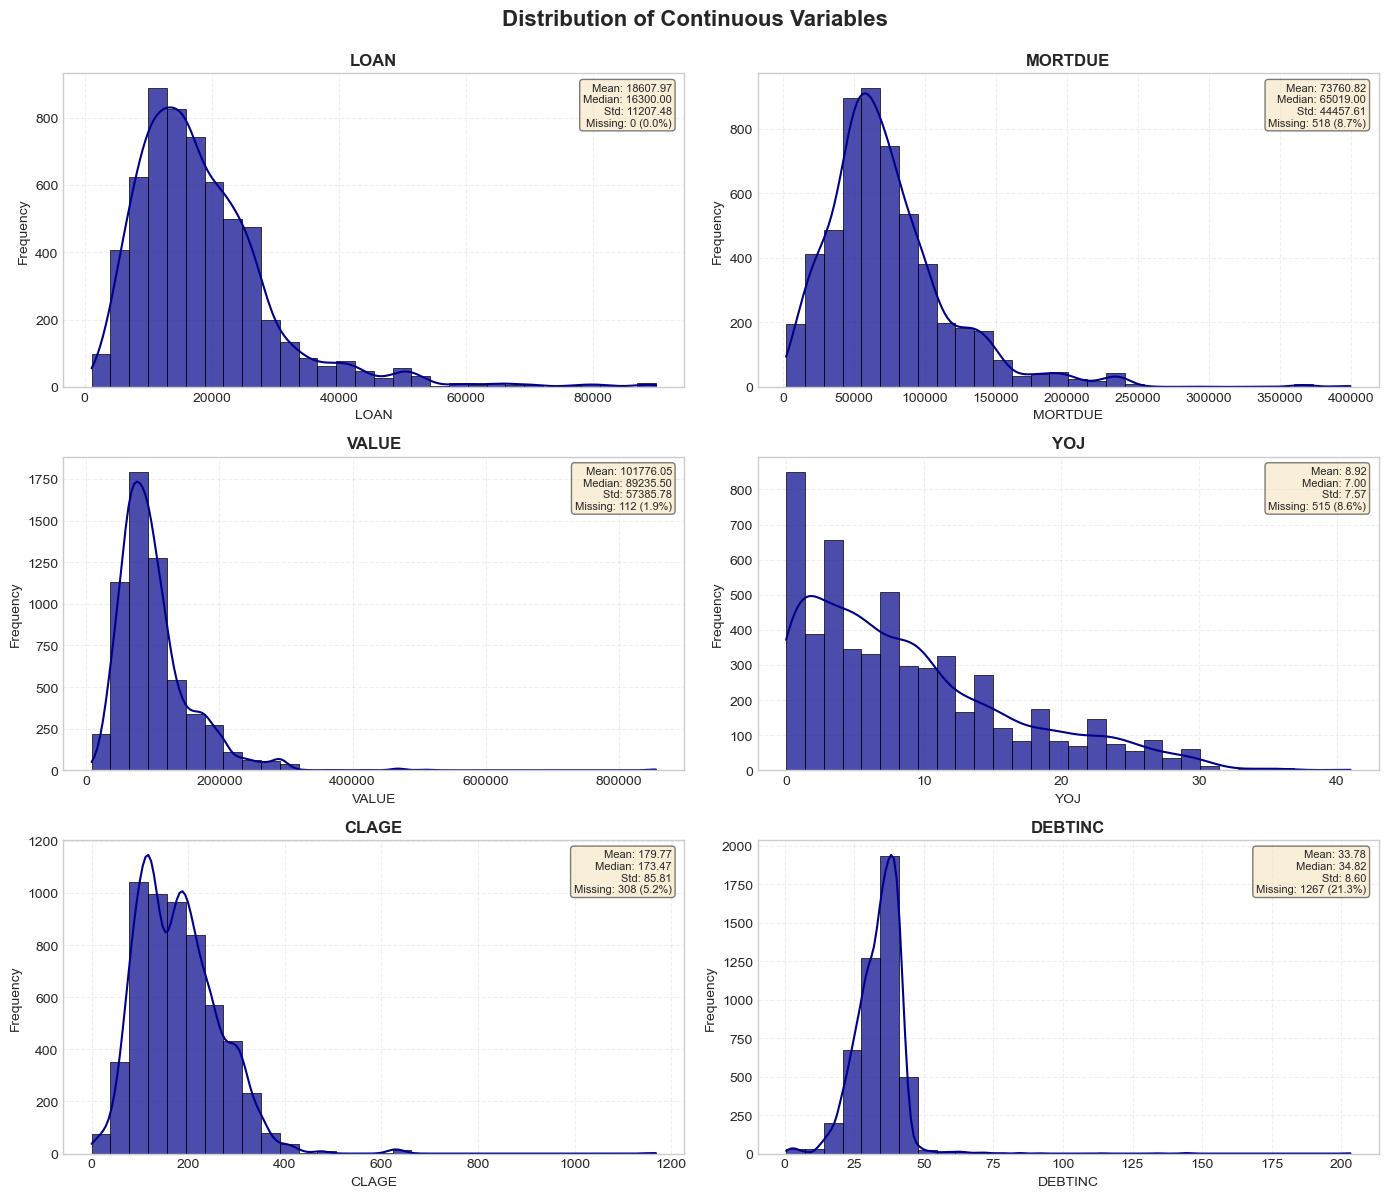

In [8]:
continuous_var = ["LOAN", "MORTDUE", "VALUE", "YOJ", "CLAGE", "DEBTINC"]

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Distribution of Continuous Variables', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, var in enumerate(continuous_var):
    data_clean = df_hmeq[var].dropna()
    
    sb.histplot(data=data_clean, bins=30, kde=True, ax=axes[idx], 
                color='darkblue', edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Add statistics text
    mean_val = data_clean.mean()
    median_val = data_clean.median()
    std_val = data_clean.std()
    missing = df_hmeq[var].isnull().sum()
    missing_pct = (missing / len(df_hmeq)) * 100
    
    # Format the title and labels
    axes[idx].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    
    # Add statistics as text box
    stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nMissing: {missing} ({missing_pct:.1f}%)'
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grid for better readability
    axes[idx].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

<span style="border-bottom: 2px solid lime;"> For discrete variables : </span> DEROG, DELINQ, NINQ, CLNO

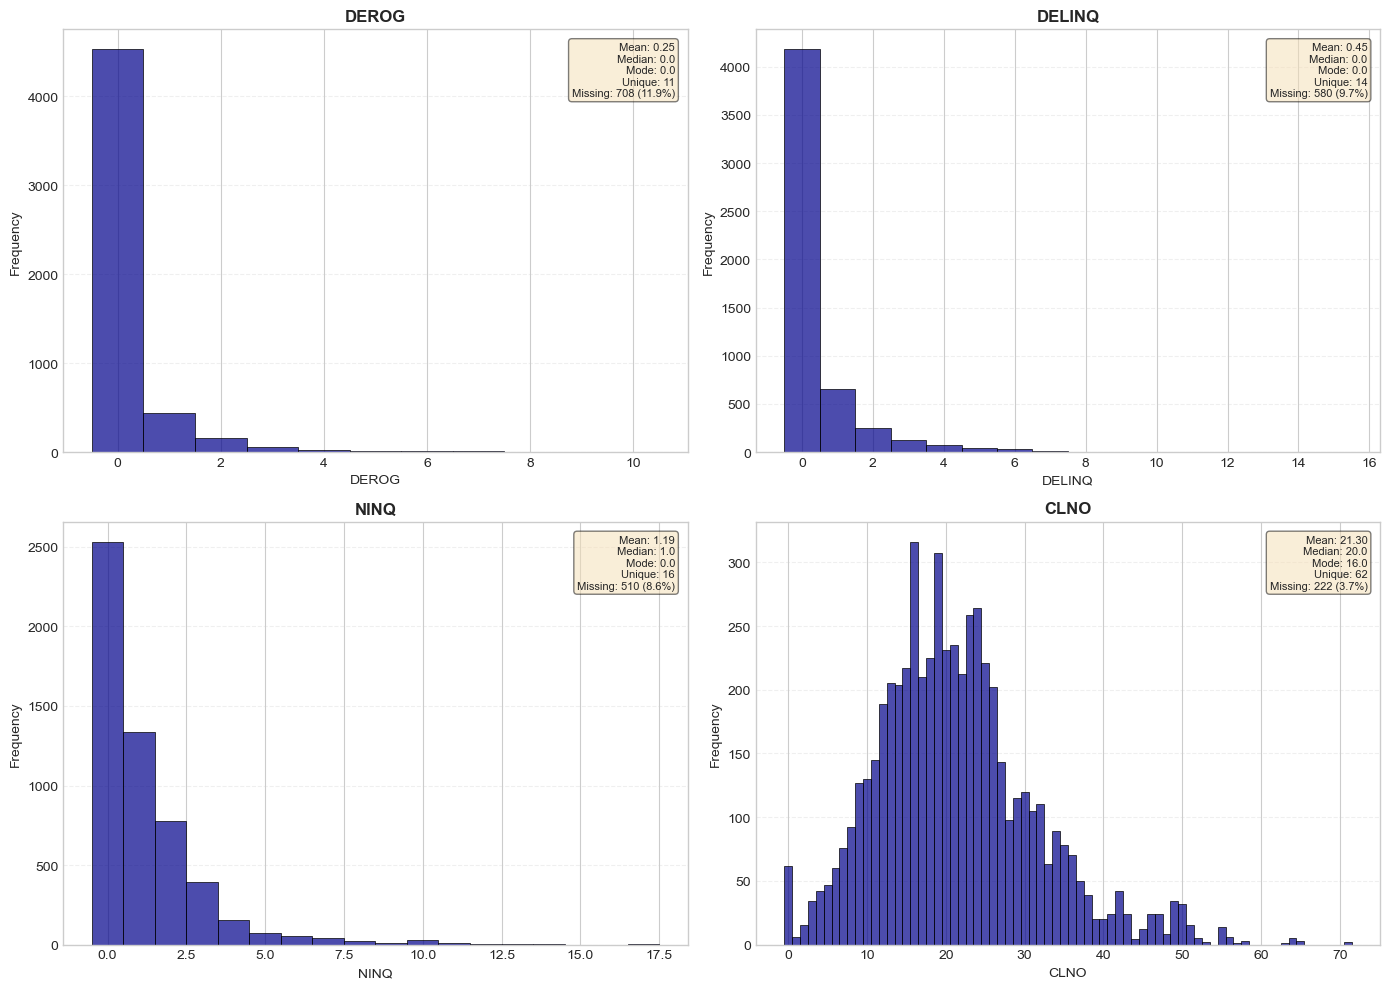

In [9]:
# Create cleaned histograms for discrete variables
discrete_var = ["DEROG", "DELINQ", "NINQ", "CLNO"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, var in enumerate(discrete_var):
    data_clean = df_hmeq[var].dropna()
    sb.histplot(data=data_clean, discrete=True, ax=axes[idx], 
                color='darkblue', edgecolor='black', linewidth=0.5, alpha=0.7)
    
    mean_val = data_clean.mean()
    median_val = data_clean.median()
    mode_val = data_clean.mode()[0] if len(data_clean.mode()) > 0 else 'N/A'
    missing = df_hmeq[var].isnull().sum()
    missing_pct = (missing / len(df_hmeq)) * 100
    unique_vals = data_clean.nunique()
    
    axes[idx].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    
    stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.1f}\nMode: {mode_val}\nUnique: {unique_vals}\nMissing: {missing} ({missing_pct:.1f}%)'
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grid for better readability
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()


<span style="border-bottom: 2px solid lime;"> For categorical variables : </span> REASON, JOB

In [10]:
# Frequency tables for categorical variables
categorical_var = ["REASON", "JOB"]

print("="*80)
print("FREQUENCY TABLES FOR CATEGORICAL VARIABLES")
print("="*80)

for var in categorical_var:
    print(f"\n{var} - Frequency Table:")
    print("-"*80)
    
    # Calculate frequencies
    freq_table = df_hmeq[var].value_counts(dropna=False)
    freq_pct = df_hmeq[var].value_counts(normalize=True, dropna=False) * 100
    
    # Create a DataFrame for better display
    freq_df = pd.DataFrame({
        'Value': freq_table.index,
        'Count': freq_table.values,
        'Percentage': freq_pct.values
    })
    
    # Format the percentage column
    freq_df['Percentage'] = freq_df['Percentage'].apply(lambda x: f"{x:.2f}%")
    
    # Replace NaN with 'Missing' for display
    freq_df['Value'] = freq_df['Value'].fillna('Missing')
    
    # Add total row
    total_count = df_hmeq[var].count()
    missing_count = df_hmeq[var].isnull().sum()
    total_rows = len(df_hmeq)
    
    print(freq_df.to_string(index=False))
    print("-"*80)
    print(f"Total observations: {total_rows}")
    print(f"Non-missing: {total_count} ({(total_count/total_rows)*100:.2f}%)")
    print(f"Missing: {missing_count} ({(missing_count/total_rows)*100:.2f}%)")
    print("="*80)

FREQUENCY TABLES FOR CATEGORICAL VARIABLES

REASON - Frequency Table:
--------------------------------------------------------------------------------
  Value  Count Percentage
DebtCon   3928     65.91%
HomeImp   1780     29.87%
Missing    252      4.23%
--------------------------------------------------------------------------------
Total observations: 5960
Non-missing: 5708 (95.77%)
Missing: 252 (4.23%)

JOB - Frequency Table:
--------------------------------------------------------------------------------
  Value  Count Percentage
  Other   2388     40.07%
ProfExe   1276     21.41%
 Office    948     15.91%
    Mgr    767     12.87%
Missing    279      4.68%
   Self    193      3.24%
  Sales    109      1.83%
--------------------------------------------------------------------------------
Total observations: 5960
Non-missing: 5681 (95.32%)
Missing: 279 (4.68%)


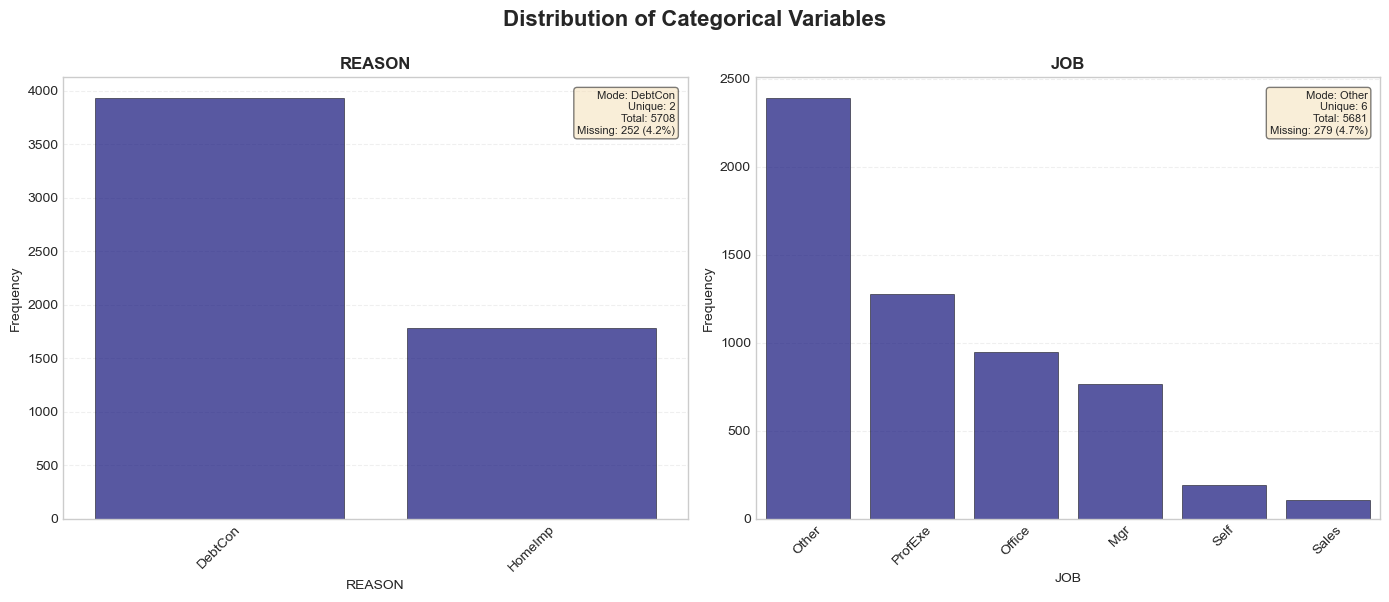

In [11]:
# Visualize categorical variables in the same style
categorical_var = ["REASON", "JOB"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution of Categorical Variables', fontsize=16, fontweight='bold', y=0.995)
axes = axes.flatten()

for idx, var in enumerate(categorical_var):
    # Get value counts (excluding NaN for the plot)
    data_clean = df_hmeq[var].dropna()
    value_counts = data_clean.value_counts()
    
    # Create bar plot
    sb.barplot(x=value_counts.index, y=value_counts.values, ax=axes[idx],
               color='darkblue', edgecolor='black', linewidth=0.5, alpha=0.7)
    
    # Calculate statistics
    mode_val = data_clean.mode()[0] if len(data_clean.mode()) > 0 else 'N/A'
    missing = df_hmeq[var].isnull().sum()
    missing_pct = (missing / len(df_hmeq)) * 100
    unique_vals = data_clean.nunique()
    total_count = len(data_clean)
    
    # Format the title and labels
    axes[idx].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    
    # Add statistics as text box
    stats_text = f'Mode: {mode_val}\nUnique: {unique_vals}\nTotal: {total_count}\nMissing: {missing} ({missing_pct:.1f}%)'
    axes[idx].text(0.98, 0.97, stats_text, transform=axes[idx].transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Grid for better readability
    axes[idx].grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()


In [12]:
# Creation of dummies variable from categorical variables

# First, fill missing values with 'Missing' category to preserve information
df_hmeq['REASON'] = df_hmeq['REASON'].fillna('Missing')
df_hmeq['JOB'] = df_hmeq['JOB'].fillna('Missing')

# Create dummy variables with drop_first=True to avoid multicollinearity
df_encoded = pd.get_dummies(df_hmeq, columns=['REASON', 'JOB'], drop_first=True) # Each categorical variable gets its own reference category

print("Encoded dataset shape:", df_encoded.shape)
print("\nNew dummy variable columns created:")
print(df_encoded.columns.tolist())
print(df_encoded.head(10))

Encoded dataset shape: (5960, 19)

New dummy variable columns created:
['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON_HomeImp', 'REASON_Missing', 'JOB_Missing', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']
   BAD  LOAN  MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  CLNO  \
0    1  1100  25860.0   39025.0  10.5    0.0     0.0   94.366667   1.0   9.0   
1    1  1300  70053.0   68400.0   7.0    0.0     2.0  121.833333   0.0  14.0   
2    1  1500  13500.0   16700.0   4.0    0.0     0.0  149.466667   1.0  10.0   
3    1  1500      NaN       NaN   NaN    NaN     NaN         NaN   NaN   NaN   
4    0  1700  97800.0  112000.0   3.0    0.0     0.0   93.333333   0.0  14.0   
5    1  1700  30548.0   40320.0   9.0    0.0     0.0  101.466002   1.0   8.0   
6    1  1800  48649.0   57037.0   5.0    3.0     2.0   77.100000   1.0  17.0   
7    1  1800  28502.0   43034.0  11.0    0.0     0.0   88.766030   0.0   

<span style="border-bottom: 2px solid lime;"> Missing Data Imputation for Numerical Variables </span>

In [13]:
# Imputation of missing values for numerical variables
# Using median for continuous variables and mode for discrete variables

# Define continuous and discrete variables
continuous_vars = ["MORTDUE", "VALUE", "YOJ", "CLAGE", "DEBTINC"]
discrete_vars = ["DEROG", "DELINQ", "NINQ", "CLNO"]

# Check missing values before imputation
print("\nMissing values BEFORE imputation:")

all_numeric_vars = continuous_vars + discrete_vars
for var in all_numeric_vars:
    missing_count = df_encoded[var].isnull().sum()
    missing_pct = (missing_count / len(df_encoded)) * 100
    print(f"{var:15} : {missing_count:4} ({missing_pct:5.2f}%)")

# Impute continuous variables with MEDIAN
print("\n" + "="*80)
print("CONTINUOUS VARIABLES - Median Imputation")
print("="*80)
for var in continuous_vars:
    median_val = df_encoded[var].median()
    df_encoded[var] = df_encoded[var].fillna(median_val)
    print(f"{var:15} : Imputed with median = {median_val:.2f}")

# Impute discrete variables with MODE
print("\n" + "="*80)
print("DISCRETE VARIABLES - Mode Imputation")
print("="*80)
for var in discrete_vars:
    mode_val = df_encoded[var].mode()[0]
    df_encoded[var] = df_encoded[var].fillna(mode_val)
    print(f"{var:15} : Imputed with mode = {mode_val}")

# Verify no missing values remain
print("\n" + "="*80)
print("Missing values AFTER imputation:")
print("-"*80)
for var in all_numeric_vars:
    missing_count = df_encoded[var].isnull().sum()
    print(f"{var:15} : {missing_count:4} missing values")

print("\n" + "="*80)
print(f"Total missing values in dataset: {df_encoded.isnull().sum().sum()}")
print("="*80)


Missing values BEFORE imputation:
MORTDUE         :  518 ( 8.69%)
VALUE           :  112 ( 1.88%)
YOJ             :  515 ( 8.64%)
CLAGE           :  308 ( 5.17%)
DEBTINC         : 1267 (21.26%)
DEROG           :  708 (11.88%)
DELINQ          :  580 ( 9.73%)
NINQ            :  510 ( 8.56%)
CLNO            :  222 ( 3.72%)

CONTINUOUS VARIABLES - Median Imputation
MORTDUE         : Imputed with median = 65019.00
VALUE           : Imputed with median = 89235.50
YOJ             : Imputed with median = 7.00
CLAGE           : Imputed with median = 173.47
DEBTINC         : Imputed with median = 34.82

DISCRETE VARIABLES - Mode Imputation
DEROG           : Imputed with mode = 0.0
DELINQ          : Imputed with mode = 0.0
NINQ            : Imputed with mode = 0.0
CLNO            : Imputed with mode = 16.0

Missing values AFTER imputation:
--------------------------------------------------------------------------------
MORTDUE         :    0 missing values
VALUE           :    0 missing values
Y

<span style="border-bottom: 2px solid lime;"> Train/Test Split and Feature Scaling </span>

In [14]:
# Train/Test Split and Feature Scaling
# Only scale continuous/discrete numerical variables, NOT binary dummy variables

# 1. Separate features (X) and target (y)
X = df_encoded.drop('BAD', axis=1)
y = df_encoded['BAD']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Preserve class distribution
)

print(f"\nTrain/Test split:")
print(f"  - Train size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Train target distribution: {y_train.value_counts().to_dict()}")
print(f"  - Test target distribution: {y_test.value_counts().to_dict()}")

continuous_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'DEBTINC', 
                   'DEROG', 'DELINQ', 'NINQ', 'CLNO']
dummy_cols = ['REASON_HomeImp', 'REASON_Missing', 'JOB_Missing', 'JOB_Office', 
              'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']


scaler = StandardScaler()

X_train_continuous = X_train[continuous_cols]
X_test_continuous = X_test[continuous_cols]


X_train_continuous_scaled = scaler.fit_transform(X_train_continuous)

# Transform TEST using the same scaler (NO FITTING on test!)
X_test_continuous_scaled = scaler.transform(X_test_continuous)

X_train_continuous_scaled = pd.DataFrame(
    X_train_continuous_scaled, 
    columns=continuous_cols, 
    index=X_train.index
)

X_test_continuous_scaled = pd.DataFrame(
    X_test_continuous_scaled, 
    columns=continuous_cols, 
    index=X_test.index
)


# Combine everything
X_train_scaled = pd.concat([X_train_continuous_scaled, X_train[dummy_cols]], axis=1)
X_test_scaled = pd.concat([X_test_continuous_scaled, X_test[dummy_cols]], axis=1)


# Convert boolean dummy columns to int (0 and 1)
X_train_scaled[dummy_cols] = X_train_scaled[dummy_cols].astype(int)
X_test_scaled[dummy_cols] = X_test_scaled[dummy_cols].astype(int)

print(f"\nFinal scaled datasets:")
print(f"  - X_train_scaled shape: {X_train_scaled.shape}")
print(f"  - X_test_scaled shape: {X_test_scaled.shape}")
print(f"  - y_train shape: {y_train.shape}")
print(f"  - y_test shape: {y_test.shape}")

# Display first few rows to verify
print("\nFirst 5 rows of X_train_scaled:")
print(X_train_scaled.head())


Train/Test split:
  - Train size: 4768 (80.0%)
  - Test size: 1192 (20.0%)
  - Train target distribution: {0: 3817, 1: 951}
  - Test target distribution: {0: 954, 1: 238}

Final scaled datasets:
  - X_train_scaled shape: (4768, 18)
  - X_test_scaled shape: (1192, 18)
  - y_train shape: (4768,)
  - y_test shape: (1192,)

First 5 rows of X_train_scaled:
          LOAN   MORTDUE     VALUE       YOJ     CLAGE   DEBTINC     DEROG  \
609  -0.964574 -0.058206 -0.346217 -0.788635 -0.452090 -0.311053 -0.281579   
4015  0.219783 -0.571361 -0.526317 -0.103049 -1.558535 -0.143557 -0.281579   
1591 -0.626186 -0.231062 -0.359731 -0.788635 -0.359107 -0.676732 -0.281579   
1127 -0.768665 -0.415236 -0.514574 -0.240166 -0.801185  0.795497 -0.281579   
920  -0.848809 -0.604069  0.063615 -0.377283  0.573591  0.112778 -0.281579   

        DELINQ      NINQ      CLNO  REASON_HomeImp  REASON_Missing  \
609  -0.374235 -0.645504  0.984795               0               0   
4015 -0.374235  1.138363 -1.098612  

In [15]:
# FEATURE ENGINEERING
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_continuous)
X_test_poly = poly.transform(X_test_continuous)

scaler_FE = StandardScaler()
X_FE_train_continuous_scaled = scaler_FE.fit_transform(X_train_poly)
X_FE_test_continuous_scaled = scaler_FE.transform(X_test_poly)

feature_names = continuous_cols
degree = 2
poly_feature_names = []

poly_feature_names.extend(feature_names)
for i, j in itertools.combinations(range(len(feature_names)), 2):
    poly_feature_names.append(f"{feature_names[i]}*{feature_names[j]}")

print(poly_feature_names)  # first 10 names
print(len(poly_feature_names))   # should match X_train_poly.shape[1]


X_FE_train_continuous_scaled = pd.DataFrame(
    X_FE_train_continuous_scaled,
    columns=poly_feature_names,
    index=X_train.index
)
print(len(X_FE_train_continuous_scaled.columns))
X_FE_test_continuous_scaled = pd.DataFrame(
    X_FE_test_continuous_scaled,
    columns=poly_feature_names,
    index=X_test.index
)

X_FE_train_full = pd.concat(
    [
        X_FE_train_continuous_scaled,        # 55 poly features
        X_train[dummy_cols]                  # 8 dummy features
    ], 
    axis=1
)

X_FE_test_full = pd.concat(
    [
        X_FE_test_continuous_scaled,
        X_test[dummy_cols]
    ],
    axis=1
)

X_FE_train_full[dummy_cols] = X_FE_train_full[dummy_cols].astype(int)
X_FE_test_full[dummy_cols] = X_FE_test_full[dummy_cols].astype(int)

print(f"\nFeature-engineered scaled datasets:")
print(f"  - X_FE_train_scaled shape: {X_FE_train_full.shape}")
print(f"  - X_FE_test_scaled shape: {X_FE_test_full.shape}")



['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'DEBTINC', 'DEROG', 'DELINQ', 'NINQ', 'CLNO', 'LOAN*MORTDUE', 'LOAN*VALUE', 'LOAN*YOJ', 'LOAN*CLAGE', 'LOAN*DEBTINC', 'LOAN*DEROG', 'LOAN*DELINQ', 'LOAN*NINQ', 'LOAN*CLNO', 'MORTDUE*VALUE', 'MORTDUE*YOJ', 'MORTDUE*CLAGE', 'MORTDUE*DEBTINC', 'MORTDUE*DEROG', 'MORTDUE*DELINQ', 'MORTDUE*NINQ', 'MORTDUE*CLNO', 'VALUE*YOJ', 'VALUE*CLAGE', 'VALUE*DEBTINC', 'VALUE*DEROG', 'VALUE*DELINQ', 'VALUE*NINQ', 'VALUE*CLNO', 'YOJ*CLAGE', 'YOJ*DEBTINC', 'YOJ*DEROG', 'YOJ*DELINQ', 'YOJ*NINQ', 'YOJ*CLNO', 'CLAGE*DEBTINC', 'CLAGE*DEROG', 'CLAGE*DELINQ', 'CLAGE*NINQ', 'CLAGE*CLNO', 'DEBTINC*DEROG', 'DEBTINC*DELINQ', 'DEBTINC*NINQ', 'DEBTINC*CLNO', 'DEROG*DELINQ', 'DEROG*NINQ', 'DEROG*CLNO', 'DELINQ*NINQ', 'DELINQ*CLNO', 'NINQ*CLNO']
55
55

Feature-engineered scaled datasets:
  - X_FE_train_scaled shape: (4768, 63)
  - X_FE_test_scaled shape: (1192, 63)


<span style="border-bottom: 2px solid orange;">TRAINING / CLASSIFICATION MODELS : </span> we are implementing logistic regression / random forest / gradient boosting at first


In [16]:
"""param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.2 * i for i in range(1,5)],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['l2'],
        'C': [0.2 * i for i in range(1,5)],
        'class_weight': [None, 'balanced']
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.2 * i for i in range(2,7)],
        'l1_ratio': [0.05*i for i in range(1,20)],
        'class_weight': [None, 'balanced']
    }
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    LogisticRegression(
        solver='saga',
        max_iter=5000,
        random_state=42
    ),
    param_grid,
    cv=cv,
    scoring='roc_auc'
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
#best_model = grid.best_estimator_
#best_model.score(X_test_scaled, y_test)"""


'param_grid = [\n    {\n        \'penalty\': [\'l1\'],\n        \'C\': [0.2 * i for i in range(1,5)],\n        \'class_weight\': [None, \'balanced\']\n    },\n    {\n        \'penalty\': [\'l2\'],\n        \'C\': [0.2 * i for i in range(1,5)],\n        \'class_weight\': [None, \'balanced\']\n    },\n    {\n        \'penalty\': [\'elasticnet\'],\n        \'C\': [0.2 * i for i in range(2,7)],\n        \'l1_ratio\': [0.05*i for i in range(1,20)],\n        \'class_weight\': [None, \'balanced\']\n    }\n]\n\ncv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n\ngrid = GridSearchCV(\n    LogisticRegression(\n        solver=\'saga\',\n        max_iter=5000,\n        random_state=42\n    ),\n    param_grid,\n    cv=cv,\n    scoring=\'roc_auc\'\n)\n\ngrid.fit(X_train_scaled, y_train)\n\nprint("Best parameters:", grid.best_params_)\n#best_model = grid.best_estimator_\n#best_model.score(X_test_scaled, y_test)'

In [17]:
# Randomized search can also be useful
# Define the distribution for hyperparameters

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = [
    {   # L1
        'penalty': ['l1'],
        'C': uniform(0.2, 1.0),
        'class_weight': [None, 'balanced']
    },
    {   # L2
        'penalty': ['l2'],
        'C': uniform(0.2, 1.0),
        'class_weight': [None, 'balanced']
    },
    {   # ElasticNet
        'penalty': ['elasticnet'],
        'C': uniform(0.2, 1.0),
        'l1_ratio': uniform(0.05, 0.9),
        'class_weight': [None, 'balanced']
    }
]


# Stratified 5-fold CV --> keep the same cv

# Randomized search
random_search = RandomizedSearchCV(
    LogisticRegression(
        solver='saga',
        max_iter=5000,
        random_state=10
    ),
    param_distributions=param_dist,
    n_iter=100,       # number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    random_state=10,
    refit=True        # refit the best model on the whole training set
)

random_search.fit(X_train_scaled, y_train)
log_reg = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)
print("Best model :", log_reg)


Best parameters: {'C': np.float64(0.3139843618635498), 'class_weight': 'balanced', 'l1_ratio': np.float64(0.8177386912867926), 'penalty': 'elasticnet'}
Best model : LogisticRegression(C=np.float64(0.3139843618635498), class_weight='balanced',
                   l1_ratio=np.float64(0.8177386912867926), max_iter=5000,
                   penalty='elasticnet', random_state=10, solver='saga')


In [18]:
# For feature engineering
fe_random_search = RandomizedSearchCV(
    LogisticRegression(
        solver='saga',
        max_iter=5000,
        random_state=10
    ),
    param_distributions=param_dist,
    n_iter=100,       # number of random combinations to try
    cv=cv,
    scoring='roc_auc',
    random_state=10,
    refit=True        # refit the best model on the whole training set
)

fe_random_search.fit(X_FE_train_full, y_train)
log_reg_fe = fe_random_search.best_estimator_
print("Best parameters:", fe_random_search.best_params_)
print("Best model :", log_reg)


Best parameters: {'C': np.float64(0.3760421332836939), 'class_weight': None, 'penalty': 'l2'}
Best model : LogisticRegression(C=np.float64(0.3139843618635498), class_weight='balanced',
                   l1_ratio=np.float64(0.8177386912867926), max_iter=5000,
                   penalty='elasticnet', random_state=10, solver='saga')


In [19]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_model = CalibratedClassifierCV(
    estimator=log_reg,
    method='sigmoid',   # or 'isotonic'
    cv=5
)

calibrated_model.fit(X_train_scaled, y_train)
y_prob_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]

In [20]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 50],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestClassifier(
    class_weight='balanced',  # keep this fixed
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=100,                # 50 random combinations
    scoring='roc_auc',        # credit risk metric
    cv=5,                     # 5-fold cross-validation
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best ROC-AUC:", random_search.best_score_)


print("Random Forest fitted!")

Best parameters: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': None}
Best ROC-AUC: 0.9476911995151912
Random Forest fitted!


In [21]:
best_rf = random_search.best_estimator_
feature_importances = best_rf.feature_importances_
features = X_train.columns
pd.Series(feature_importances, index=features).sort_values(ascending=False)


DEBTINC           0.323160
DELINQ            0.117744
CLAGE             0.110164
LOAN              0.079469
VALUE             0.067954
MORTDUE           0.061472
CLNO              0.057789
DEROG             0.053001
YOJ               0.046789
NINQ              0.034588
JOB_Office        0.011056
JOB_Other         0.010629
REASON_HomeImp    0.008029
JOB_Missing       0.005928
JOB_ProfExe       0.005159
JOB_Sales         0.004333
REASON_Missing    0.001507
JOB_Self          0.001227
dtype: float64

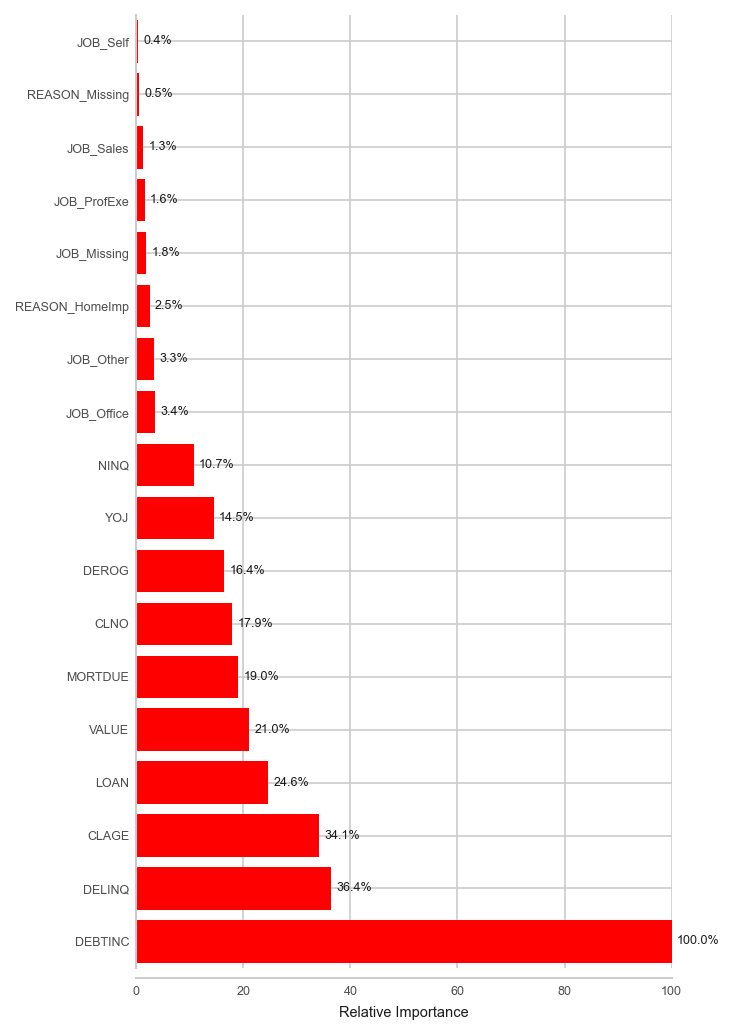

In [22]:
import matplotlib.transforms as transforms

# Styling colors
GRAY1 = '#4d4d4d'  # tick labels
GRAY4 = '#1a1a1a'  # axis labels

features = X_train.columns

def plot_relative_feature_importance_with_percent(importance, features):
    max_importance = np.max(importance)
    # Compute relative importance as percentage of max
    relative_importance = sorted(zip(100*importance/max_importance, features))
    
    yticks = np.arange(len(relative_importance))
    yticklabels = [ri[1] for ri in relative_importance][::-1]
    bars_sizes = [ri[0] for ri in relative_importance][::-1]

    fig, ax = plt.subplots(figsize=(5, 7), dpi=150)
    bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
    
    plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
    
    ax.set_xlim([0, 100])
    ax.set_ylim([-0.5, len(yticks)-0.5])
    
    # Add percentages on bars
    for bar, value in zip(bars, bars_sizes):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}%', va='center', fontsize=6, color=GRAY4)
    
    # Style ticks and labels
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(6)
        e.set_color(GRAY1)
    ax.tick_params(left=False)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
    for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + [ax.spines['bottom']]:
        e.set_transform(e.get_transform() + offset)
    
    ax.spines['bottom'].set_bounds(0, 100)
    _ = ax.set_xlabel('Relative Importance', color=GRAY4, fontsize=7)

# Call the function
plot_relative_feature_importance_with_percent(best_rf.feature_importances_, features)

plt.tight_layout()
plt.show()

In [23]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=50,           # number of random combinations
    scoring='roc_auc',   # best metric for credit risk
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best CV ROC-AUC:", random_search.best_score_)

Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 500, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 6, 'learning_rate': 0.1}
Best CV ROC-AUC: 0.9733479864221772


DEBTINC           0.260351
DELINQ            0.113583
CLAGE             0.096850
VALUE             0.092848
LOAN              0.086981
MORTDUE           0.073413
CLNO              0.063117
DEROG             0.059767
YOJ               0.056150
NINQ              0.044066
JOB_Other         0.010343
JOB_Office        0.009686
REASON_HomeImp    0.008721
JOB_ProfExe       0.007033
JOB_Sales         0.006182
JOB_Missing       0.004428
REASON_Missing    0.003985
JOB_Self          0.002496
dtype: float64


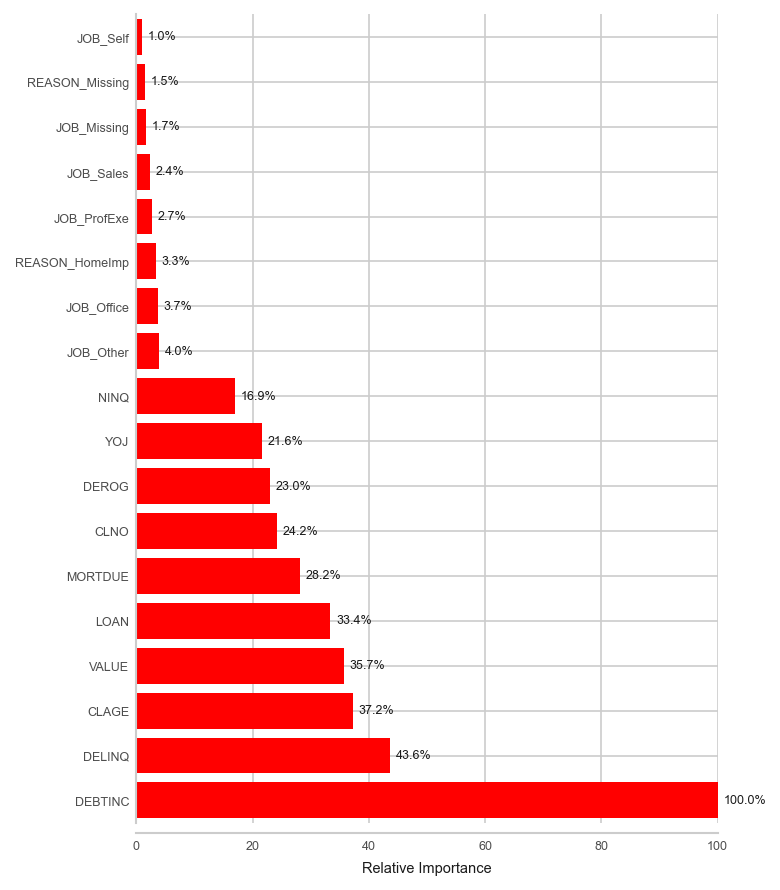

In [24]:
best_gb = random_search.best_estimator_
feature_importances = best_gb.feature_importances_

# Sort and display
fi_series = pd.Series(feature_importances, index=features).sort_values(ascending=False)
print(fi_series)

# Optional: relative importance plot
plot_relative_feature_importance_with_percent(feature_importances, features)


<span style="border-bottom: 2px solid orange;">PREDICTIONS </span>

In [25]:
y_pred_logreg = log_reg.predict(X_test_scaled)
y_prob_logreg = log_reg.predict_proba(X_test_scaled)[:, 1]  # P(default)

y_pred_logreg_FE = log_reg_fe.predict(X_FE_test_full)
y_prob_logreg_FE = log_reg_fe.predict_proba(X_FE_test_full)[:, 1]  # P(default)


# Random Forest (uses unscaled data)
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Gradient Boosting (uses unscaled data)
y_pred_gb = best_gb.predict(X_test)
y_prob_gb = best_gb.predict_proba(X_test)[:, 1]

print("Predictions generated!")


Predictions generated!


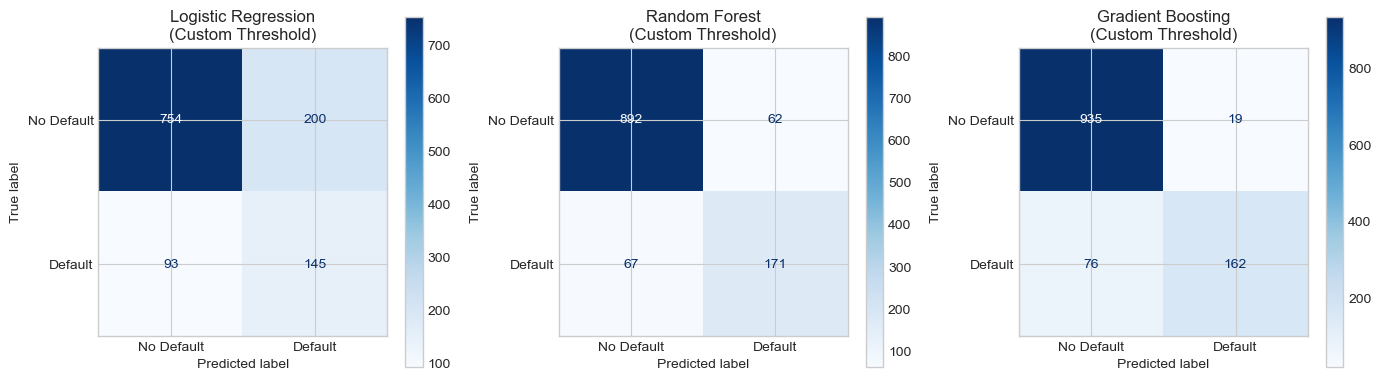

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, y_pred_custom) in zip(axes, [
    ('Logistic Regression', y_pred_logreg),
    ('Random Forest', y_pred_rf),
    ('Gradient Boosting', y_pred_gb)
]):
    # Create confusion matrix display
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_custom,
        display_labels=['No Default', 'Default'],
        cmap='Blues',
        ax=ax
    )
    ax.set_title(f"{name}\n(Custom Threshold)")

plt.tight_layout()
plt.show()


<span style="border-bottom: 2px solid orange;">FP + FN Cost analysis </span>

In [27]:
avg_loan_good = df_encoded[df_encoded['BAD'] == 0]['LOAN'].mean()
avg_loan_bad = df_encoded[df_encoded['BAD'] == 1]['LOAN'].mean()
print(f"Average loan amount (good borrowers):  ${avg_loan_good:,.2f}")
print(f"Average loan amount (defaulters):      ${avg_loan_bad:,.2f}")

#COST_FN
# Use ORIGINAL data (before imputation) - only complete cases
defaulted_loans_original = df_hmeq[
    (df_hmeq['BAD'] == 1) &
    (df_hmeq['VALUE'].notna()) &
    (df_hmeq['LOAN'].notna()) &
    (df_hmeq['MORTDUE'].notna())
].copy()

# Calculate gross recovery rate: VALUE / (MORTDUE + LOAN)
defaulted_loans_original['gross_recovery_pct'] = (
    defaulted_loans_original['VALUE'] / 
    (defaulted_loans_original['MORTDUE'] + defaulted_loans_original['LOAN'])
).clip(0, 1)

avg_gross_recovery = defaulted_loans_original['gross_recovery_pct'].mean()
print(avg_gross_recovery)
# Foreclosure/workout costs reduce the recovery (typically 10-15% of exposure)
# Sources: Federal Reserve, Basel LGD studies
workout_costs_pct = 0.10  # 10% of loan for foreclosure, legal, selling costs

# Net Recovery = Gross Recovery - Workout Costs
net_recovery_rate = avg_gross_recovery - workout_costs_pct

# Loss Given Default (LGD) = 1 - Net Recovery Rate
LGD = 1 - net_recovery_rate

# Cost = Average Loan × LGD
COST_FN_ESTIMATED = avg_loan_bad * LGD

# COST_FP

profit_margin = 0.06  # 6% net profit margin over loan lifetime (realistic for home equity)
COST_FP_ESTIMATED = avg_loan_good * profit_margin


print(f"COST Approving a defaulter (FN) : {COST_FN_ESTIMATED}")
print(f"COST Denying a good borrower (FP) : {COST_FP_ESTIMATED}")



Average loan amount (good borrowers):  $19,028.11
Average loan amount (defaulters):      $16,922.12
0.9871105169481151
COST Approving a defaulter (FN) : 1910.329314379431
COST Denying a good borrower (FP) : 1141.6864389016978


In [28]:
def calculate_cost_at_threshold(y_true, y_prob, threshold, cost_fp, cost_fn):
    """
    Calculate total cost of errors at a given threshold.
    
    Parameters:
    -----------
    y_true : array, actual labels (0 or 1)
    y_prob : array, predicted probabilities
    threshold : float, classification threshold
    cost_fp : float, cost of false positive
    cost_fn : float, cost of false negative
    
    Returns:
    --------
    dict with FP count, FN count, total cost, and metrics
    """
    # Make predictions at this threshold
    y_pred = (y_prob >= threshold).astype(int)
    
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    # Calculate total cost
    total_cost = (FP * cost_fp) + (FN * cost_fn)
    
    # Calculate metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return {
        'threshold': threshold,
        'FP': FP,
        'FN': FN,
        'total_cost': total_cost,
        'precision': precision,
        'recall': recall
    }

In [29]:
thresholds = np.arange(0.01, 0.96, 0.01)

# Calculate cost at each threshold for Gradient Boosting (typically best model)
def threshold_per_model(y_prob):
    results = []
    for t in thresholds:
        result = calculate_cost_at_threshold(y_test, y_prob, t, COST_FP_ESTIMATED, COST_FN_ESTIMATED)
        results.append(result)

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Find optimal threshold (minimum total cost)
    optimal_idx = results_df['total_cost'].idxmin()
    optimal_threshold = results_df.loc[optimal_idx, 'threshold']
    optimal_cost = results_df.loc[optimal_idx, 'total_cost']

    return optimal_threshold, optimal_cost, optimal_idx, results_df

#For logistic regression :
optimal_threshold, optimal_cost, optimal_idx, results_df = threshold_per_model(y_prob_logreg)
print("For logistic regression : the threshold is :", optimal_threshold)

#For logistic regression with featuring engineering:
optimal_threshold_fe, optimal_cost_fe, optimal_idx_fe, results_df_fe = threshold_per_model(y_prob_logreg_FE)
print("For logistic regression with FE : the threshold is :", optimal_threshold_fe)


#by adding probability calibration
optimal_threshold_cal, optimal_cost_cal, optimal_idx_cal, results_df_cal = threshold_per_model(y_prob_calibrated)
print("For logistic regression with calibration, the threshold is :", optimal_threshold_cal)

#For Random Forest :
optimal_threshold_rf, optimal_cost_rf, optimal_idx_rf, results_df_rf = threshold_per_model(y_prob_rf)
print("For Random Forest : the threshold is :", optimal_threshold_rf)

# For XG Boost
optimal_threshold_gb, optimal_cost_gb, optimal_idx_gb, results_df_gb = threshold_per_model(y_prob_gb)
print("For Random Forest : the threshold is :", optimal_threshold_gb)


For logistic regression : the threshold is : 0.8
For logistic regression with FE : the threshold is : 0.44
For logistic regression with calibration, the threshold is : 0.48
For Random Forest : the threshold is : 0.37
For Random Forest : the threshold is : 0.07


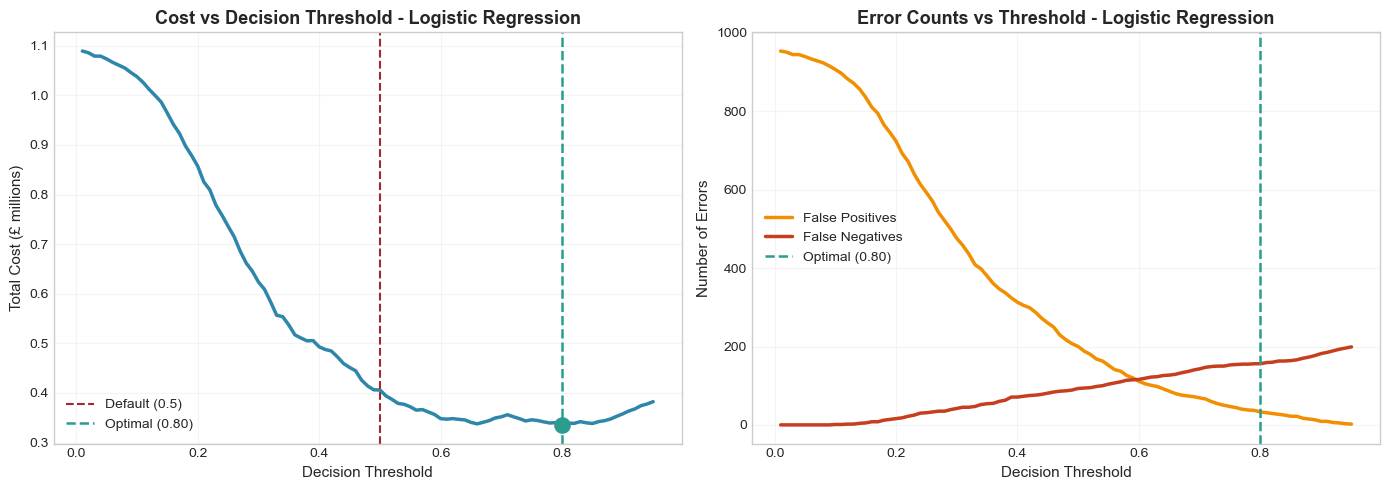

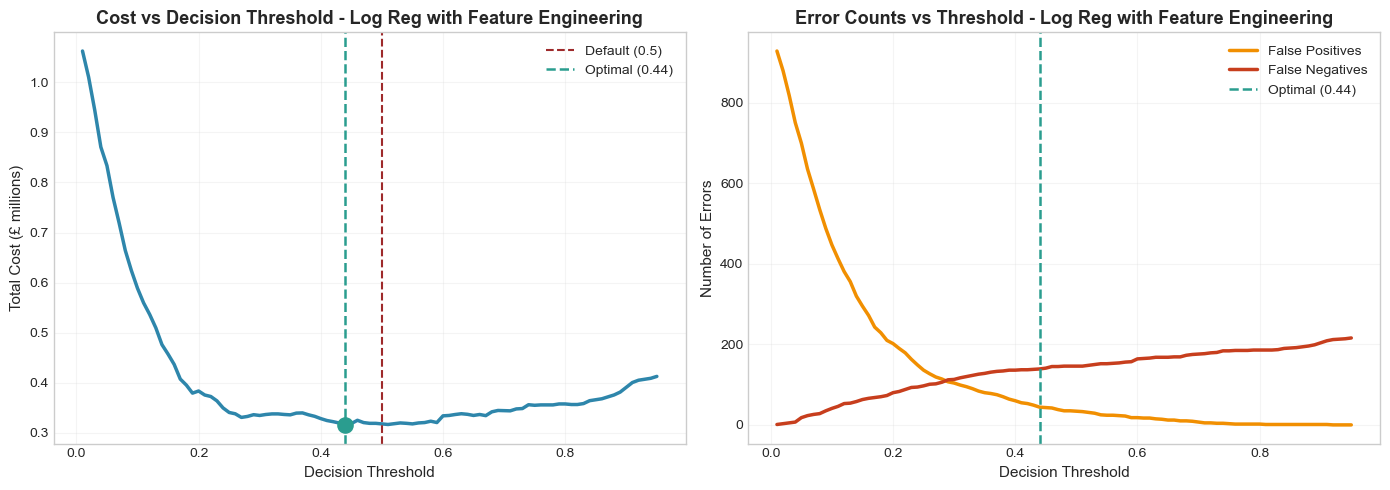

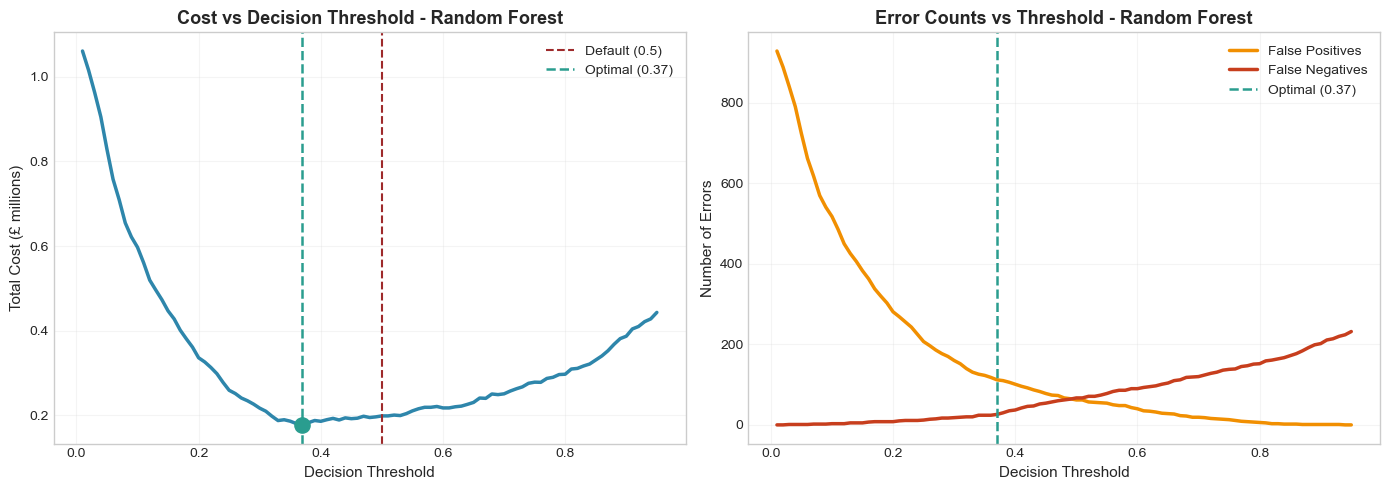

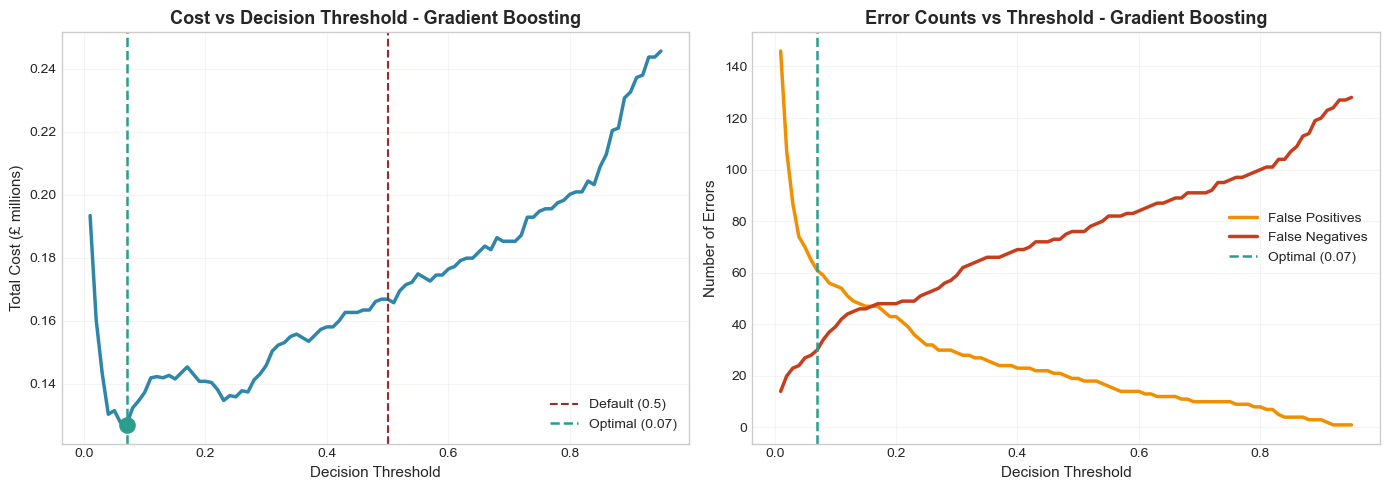

In [30]:

def plot_threshold_dynamics(name_model, optimal_threshold, optimal_cost, results_df):

    # Modern style
    plt.style.use("seaborn-v0_8-whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Modern color palette
    cost_color = "#2E86AB"      # blue
    fp_color = "#F18F01"        # orange
    fn_color = "#C73E1D"        # red
    optimal_color = "#2A9D8F"   # green
    default_color = "#9E2A2B"   # muted red

    # LEFT: Total Cost
    ax1 = axes[0]

    ax1.plot(results_df['threshold'],
             results_df['total_cost'] / 1e6,
             color=cost_color,
             linewidth=2.5)

    ax1.axvline(x=0.5,
                color=default_color,
                linestyle='--',
                linewidth=1.5,
                label='Default (0.5)')

    ax1.axvline(x=optimal_threshold,
                color=optimal_color,
                linestyle='--',
                linewidth=1.8,
                label=f'Optimal ({optimal_threshold:.2f})')

    ax1.scatter(optimal_threshold,
                optimal_cost / 1e6,
                color=optimal_color,
                s=120,
                zorder=5)

    ax1.set_xlabel('Decision Threshold', fontsize=11)
    ax1.set_ylabel('Total Cost (£ millions)', fontsize=11)
    ax1.set_title(f'Cost vs Decision Threshold - {name_model}', fontsize=13, weight='bold')
    ax1.legend()
    ax1.grid(alpha=0.2)

    # RIGHT: Error counts
    ax2 = axes[1]

    ax2.plot(results_df['threshold'],
             results_df['FP'],
             color=fp_color,
             linewidth=2.5,
             label='False Positives')

    ax2.plot(results_df['threshold'],
             results_df['FN'],
             color=fn_color,
             linewidth=2.5,
             label='False Negatives')

    ax2.axvline(x=optimal_threshold,
                color=optimal_color,
                linestyle='--',
                linewidth=1.8,
                label=f'Optimal ({optimal_threshold:.2f})')

    ax2.set_xlabel('Decision Threshold', fontsize=11)
    ax2.set_ylabel('Number of Errors', fontsize=11)
    ax2.set_title(f'Error Counts vs Threshold - {name_model}', fontsize=13, weight='bold')
    ax2.legend()
    ax2.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

plot_threshold_dynamics("Logistic Regression",optimal_threshold,optimal_cost,results_df )
plot_threshold_dynamics("Log Reg with Feature Engineering",optimal_threshold_fe, optimal_cost_fe, results_df_fe)
plot_threshold_dynamics("Random Forest", optimal_threshold_rf, optimal_cost_rf, results_df_rf)

plot_threshold_dynamics("Gradient Boosting", optimal_threshold_gb, optimal_cost_gb, results_df_gb)
#plot_threshold_dynamics(optimal_threshold_cal,optimal_cost_cal,results_df_cal )


In [31]:
y_pred_log_custom = (y_prob_logreg >= optimal_threshold).astype(int)
y_pred_rf_custom = (y_prob_rf >= optimal_threshold_rf).astype(int)
y_pred_gb_custom = (y_prob_gb >= optimal_threshold_gb).astype(int)


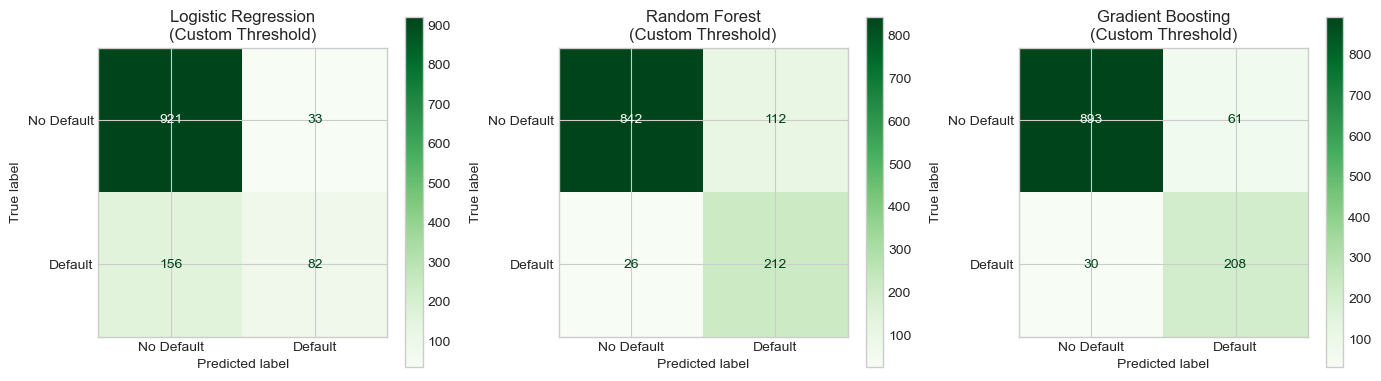

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, y_pred_custom) in zip(axes, [
    ('Logistic Regression', y_pred_log_custom),
    ('Random Forest', y_pred_rf_custom),
    ('Gradient Boosting', y_pred_gb_custom)
]):
    # Create confusion matrix display
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_custom,
        display_labels=['No Default', 'Default'],
        cmap='Greens',
        ax=ax
    )
    ax.set_title(f"{name}\n(Custom Threshold)")

plt.tight_layout()
plt.show()


In [33]:
print("Model Comparison at optimal thresholds")
print("="*60)

for name, y_pred in [
    ('Logistic Regression', y_pred_log_custom),
    ('Random Forest', y_pred_rf_custom),
    ('Gradient Boosting', y_pred_gb_custom)
]:
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

Model Comparison at optimal thresholds

Logistic Regression:
              precision    recall  f1-score   support

  No Default       0.86      0.97      0.91       954
     Default       0.71      0.34      0.46       238

    accuracy                           0.84      1192
   macro avg       0.78      0.65      0.69      1192
weighted avg       0.83      0.84      0.82      1192


Random Forest:
              precision    recall  f1-score   support

  No Default       0.97      0.88      0.92       954
     Default       0.65      0.89      0.75       238

    accuracy                           0.88      1192
   macro avg       0.81      0.89      0.84      1192
weighted avg       0.91      0.88      0.89      1192


Gradient Boosting:
              precision    recall  f1-score   support

  No Default       0.97      0.94      0.95       954
     Default       0.77      0.87      0.82       238

    accuracy                           0.92      1192
   macro avg       0.87      0.

ROC Curve and AUC - THRESHOLD INDEPENDENT

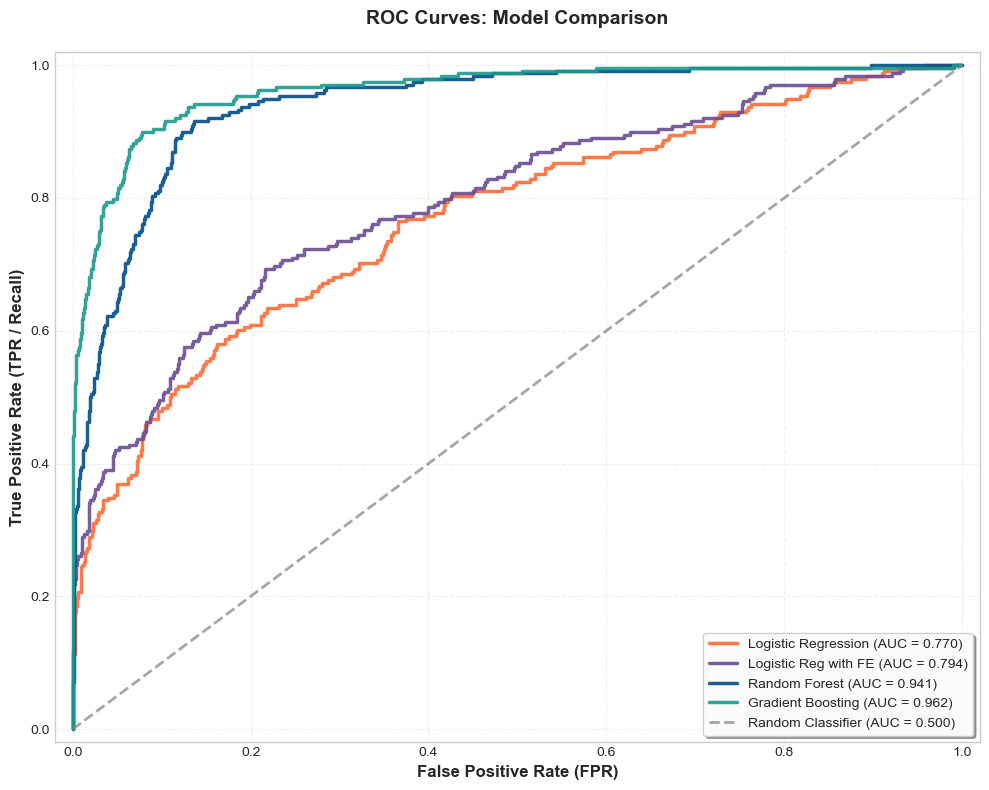


ROC-AUC SCORES SUMMARY
Logistic Regression       : AUC = 0.7699
Logistic Reg with FE      : AUC = 0.7944
Random Forest             : AUC = 0.9407
Gradient Boosting         : AUC = 0.9624


In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

# Modern color palette
colors = {
    'Logistic Regression': '#FF6B35',  # Vibrant orange
    'Logistic Reg with FE': '#6A4C93', #deep purple
    'Random Forest': '#004E89',         # Deep blue
    'Gradient Boosting': '#1B998B'      # Teal
}

# Calculate and plot ROC curve for each model
for name, y_prob in [
    ('Logistic Regression', y_prob_logreg),
    ('Logistic Reg with FE', y_prob_logreg_FE),
    ('Random Forest', y_prob_rf),
    ('Gradient Boosting', y_prob_gb)
]:
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot with modern styling
    ax.plot(fpr, tpr, color=colors[name], linewidth=2.5, 
            label=f'{name} (AUC = {roc_auc:.3f})', alpha=0.9)

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2, 
        label='Random Classifier (AUC = 0.500)', alpha=0.7)

# Styling
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (TPR / Recall)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold', pad=20)

# Legend with better styling
ax.legend(loc='lower right', fontsize=10, frameon=True, 
          fancybox=True, shadow=True, framealpha=0.95)

# Grid for better readability
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# Set axis limits
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

# Add AUC interpretation box
interpretation_text = (
    "AUC Interpretation:\n"
    "• AUC = Probability that model ranks a random\n"
    "  defaulter higher than a random non-defaulter\n"
    "• Higher AUC = Better ranking across all thresholds"
)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ROC-AUC SCORES SUMMARY")
print("="*80)
for name, y_prob in [
    ('Logistic Regression', y_prob_logreg),
        ('Logistic Reg with FE', y_prob_logreg_FE),

    ('Random Forest', y_prob_rf),
    ('Gradient Boosting', y_prob_gb)
]:
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"{name:25} : AUC = {roc_auc:.4f}")
print("="*80)

END